In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 100000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

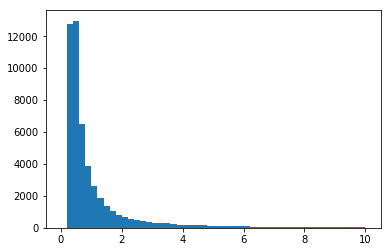

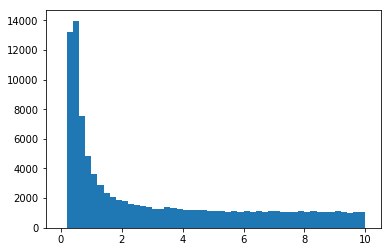

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [ mass_e,mass_mu, mass_pi, mass_K , mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    BBS_tmp = []
    BBA_tmp = []
    beta_tmp = []
    pmeas_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.01*beta) )  ## TOF - smeared with .... gaussian
        pmeas_tmp.append(np.random.normal(p,0.01*p))
        BBS_tmp.append(BBS)
        BBA_tmp.append(BBA)
        beta_tmp.append(beta)
        
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp, 'BBS': BBS_tmp, 'BBA': BBA_tmp, "beta": beta_tmp,
                   "pmeas": pmeas_tmp})

[]

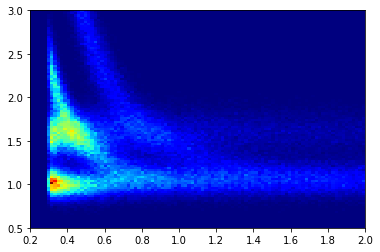

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,pmeas,p,particle,flips
0,1.316229,0.002093,0.002014,1.003660,1.338605,1.263912,1.156227,1.384459,0.999810,7.003509,7.123731,0,63
1,1.354413,0.002140,0.001929,1.002634,1.444119,1.378675,1.713754,1.299409,0.999889,9.333905,9.316006,0,61
2,1.334939,0.002116,0.001930,0.997411,1.399240,1.241414,1.223268,1.276922,0.999854,8.052037,8.120213,0,61
3,1.220755,0.001972,0.002253,0.997221,1.015243,1.279886,0.974749,1.192626,0.999285,3.681733,3.674107,0,63
4,1.343122,0.002126,0.001794,1.002377,0.992266,1.444231,1.188733,1.475059,0.999869,8.479823,8.601417,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,pmeas,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,1.316229,0.002093,0.002014,1.003660,1.338605,1.263912,1.156227,1.384459,0.999810,7.003509,...,1.338605,1.263912,1.0,1.263912,1.156227,1.0,1.156227,1.384459,1.0,1.384459
1,1.354413,0.002140,0.001929,1.002634,1.444119,1.378675,1.713754,1.299409,0.999889,9.333905,...,1.444119,1.378675,1.0,1.378675,1.713754,1.0,1.713754,1.299409,1.0,1.299409
2,1.334939,0.002116,0.001930,0.997411,1.399240,1.241414,1.223268,1.276922,0.999854,8.052037,...,1.399240,1.241414,1.0,1.241414,1.223268,1.0,1.223268,1.276922,1.0,1.276922
3,1.220755,0.001972,0.002253,0.997221,1.015243,1.279886,0.974749,1.192626,0.999285,3.681733,...,1.015243,1.279886,1.0,1.279886,0.974749,1.0,0.974749,1.192626,1.0,1.192626
4,1.343122,0.002126,0.001794,1.002377,0.992266,1.444231,1.188733,1.475059,0.999869,8.479823,...,0.992266,1.444231,1.0,1.444231,1.188733,1.0,1.188733,1.475059,1.0,1.475059
5,1.187182,0.001928,0.001955,1.000992,1.261372,1.076720,1.256739,1.172515,0.998859,2.941692,...,1.261372,1.076720,1.0,1.076720,1.256739,1.0,1.256739,1.172515,1.0,1.172515
6,1.285049,0.002054,0.001890,1.004468,1.383382,1.164106,1.133965,1.428235,0.999706,5.669830,...,1.383382,1.481670,0.0,0.000000,1.133965,1.0,1.133965,1.428235,1.0,1.428235
7,1.291016,0.002061,0.002049,0.997812,1.380595,1.300809,1.396964,1.128979,0.999730,6.010767,...,1.380595,1.481670,0.0,0.000000,1.396964,1.0,1.396964,1.128979,1.0,1.128979
8,1.278258,0.002045,0.002317,1.018174,1.324269,1.181768,1.096681,1.384790,0.999678,5.526631,...,1.324269,1.181768,1.0,1.181768,1.096681,1.0,1.096681,1.384790,1.0,1.384790
9,1.237328,0.001993,0.001970,1.014506,1.241393,1.095195,0.997875,1.071091,0.999432,4.135445,...,1.241393,1.095195,1.0,1.095195,0.997875,1.0,0.997875,1.071091,1.0,1.071091


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [10]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))

inputs = Input(shape=(7,))
inputw = Input(shape=(7,))
enc1   = Dense(units=64, activation='selu')(inputs)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='selu')(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=7, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                192       
__________

# perfect tracks

In [12]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","pmeas"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","pmeas"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD","pmeas"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 200000 samples, validate on 200000 samples
Epoch 1/5
200000/200000 [==============================] - 55s 275us/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0456 - val_mean_squared_error: 0.0456
Epoch 2/5
200000/200000 [==============================] - 54s 268us/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 3/5
200000/200000 [==============================] - 53s 265us/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0246 - val_mean_squared_error: 0.0246
Epoch 4/5
200000/200000 [==============================] - 53s 266us/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 5/5
200000/200000 [==============================] - 53s 266us/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0244 - val_mean_squared_error: 0.0244


2019-02-01 13:34:57.060897: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [14]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae", "pmeas_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)

df_test.head(3)

,index,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,...,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae,pmeas_ae
0,245573,1.065025,0.001760,0.001692,0.995296,1.113210,1.166771,1.181994,1.007410,0.993070,...,1.007410,1.0,1.007410,0.001873,0.990496,1.085167,1.099072,1.124021,1.104195,7.771983
1,164260,1.585204,0.002629,0.002550,0.988077,1.363573,1.606649,1.551058,1.594566,1.000000,...,1.594566,1.0,1.594566,0.002523,0.989696,1.523463,1.529318,1.532483,1.568717,0.368084
2,285565,4.141763,0.007361,0.007873,0.377040,4.116584,4.544295,3.520377,4.064561,0.374044,...,4.064561,1.0,4.064561,0.007367,0.379004,4.197906,4.119708,4.076267,4.015620,0.491000


In [15]:
outtr = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(train_pt)))
AE_predict_tr = pd.DataFrame(outtr)
AE_predict_tr.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae","pmeas_ae"]
train = train.reset_index()
df_train = pd.concat([train,AE_predict_tr], axis = 1)

In [16]:
for dftt in [df_test,df_train]:
    for detector in ["TPCROC0", "TPCROC1", "TPCROC2", "TRD"]:
        dftt.loc[:,"delta"+detector] = dftt["BBA"]-dftt[detector+"_ae"]
    dftt.loc[:,"deltaITS"] = dftt["BBS"]-dftt["ITS_ae"]
    dftt.loc[:,"deltaTOF"] = dftt["beta"]-dftt["TOF_ae"]

In [17]:
df_test.head()

,index,BBA,BBS,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,beta,...,TPCROC1_ae,TPCROC2_ae,TRD_ae,pmeas_ae,deltaTPCROC0,deltaTPCROC1,deltaTPCROC2,deltaTRD,deltaITS,deltaTOF
0,245573,1.065025,0.001760,0.001692,0.995296,1.113210,1.166771,1.181994,1.007410,0.993070,...,1.099072,1.124021,1.104195,7.771983,-0.020142,-0.034047,-0.058996,-0.039170,-0.000114,0.002574
1,164260,1.585204,0.002629,0.002550,0.988077,1.363573,1.606649,1.551058,1.594566,1.000000,...,1.529318,1.532483,1.568717,0.368084,0.061741,0.055886,0.052721,0.016487,0.000106,0.010304
2,285565,4.141763,0.007361,0.007873,0.377040,4.116584,4.544295,3.520377,4.064561,0.374044,...,4.119708,4.076267,4.015620,0.491000,-0.056143,0.022055,0.065496,0.126143,-0.000006,-0.004960
3,328788,2.022590,0.003495,0.003684,0.578655,2.140521,2.108916,2.084362,2.052627,0.579422,...,2.102046,2.084439,2.059515,0.394952,-0.095999,-0.079456,-0.061849,-0.036924,-0.000100,0.013475
4,51739,1.002040,0.001670,0.001830,0.985686,0.924405,0.978130,0.996785,1.049514,0.974272,...,1.019960,1.010522,0.996721,0.646437,-0.007296,-0.017921,-0.008482,0.005319,-0.000017,-0.002563


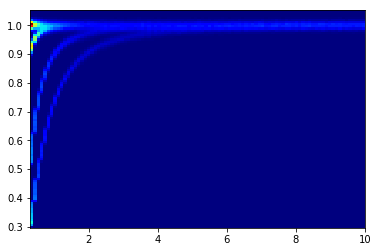

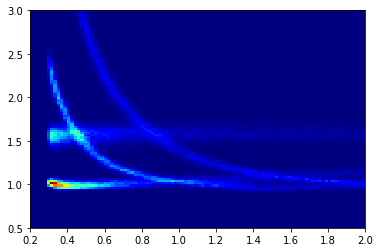

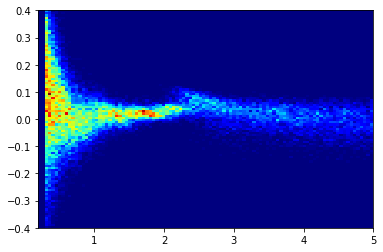

In [19]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test.query("particle==3")["p"], df_test.query("particle==3")["deltaTPCROC2"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 5], [-0.4, 0.4]])
plt.savefig("plot.pdf")
plt.show()


# Train with zeros

In [ ]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

In [ ]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

In [ ]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


In [ ]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

In [ ]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [ ]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

In [ ]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

In [ ]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [ ]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [ ]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

In [ ]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

In [ ]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [ ]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [ ]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [ ]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

In [ ]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()